# Houses prices competition

This notebook builds a predictive model for predict the sales price of houses, based on data provided on the [House Prices: Advanced Regression Techniques competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview).

In [1]:
# Load dependencies.
import numpy as np
import pandas as pd

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## 1. Load and clean data

In [2]:
# Load train and test data.
test_data_raw = pd.read_csv('./data/test.csv', sep=',')
train_data_raw = pd.read_csv('./data/train.csv', sep=',')

# Take a quick look into the data.
train_data_raw.head(8)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000


In [14]:
# Remove useless columns.
USELESS_COLUMNS = [
    'Id', 'MSSubClass', 'MiscFeature', 'MoSold', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
    'MasVnrType', 'Neighborhood', 'Heating', 'Electrical', 'GarageType', 'SaleType', 'SaleCondition'
]
train_data = train_data_raw.drop(USELESS_COLUMNS, axis=1)

# Convert some categorical columns (which represent scores) into numeric ones.
SCORES_TO_NUMBERS = {
    "Alley": {"Grvl": 1, "Pave": 2},
    "BsmtCond": {"Ex": 5, "Gd": 4, "TA": 3, "Av": 3, "Fa": 2, "Po": 1, "No": 1, "NA": 0},
    "BsmtExposure": {"Ex": 5, "Gd": 4, "TA": 3, "Av": 3, "Fa": 2, "Mn": 2, "Po": 1,  "No": 1, "NA": 0},
    "BsmtFinType1": {"GLQ": 6, "ALQ": 4, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, "NA": 0},
    "BsmtFinType2": {"GLQ": 6, "ALQ": 4, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, "NA": 0},
    "BsmtQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1,  "No": 1,"NA": 0},
    "BldgType": {"1Fam": 0, "2FmCon": 1, "2fmCon": 1, "Duplx": 2, "Duplex": 2, "Twnhs": 3, "TwnhsI": 3, "TwnhsE": 4},
    "CentralAir": {"N": 0, "Y": 1},
    "Condition1": {"PosA": 0, "PosN": 1, "Norm": 2, "Feedr": 3, "Artery": 4, "RRNn": 5, "RRNe": 5, "RRAn": 6, "RRAe": 6},
    "Condition2": {"PosA": 0, "PosN": 1, "Norm": 2, "Feedr": 3, "Artery": 4, "RRNn": 5, "RRNe": 5, "RRAn": 6, "RRAe": 6},
    "ExterCond": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "No": 1, "Po": 1},
    "ExterQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "No": 1, "Po": 1},
    "Fence": {"NA": 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4},
    "FireplaceQu": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0},
    "Foundation": {"BrkTil": 0, "CBlock": 1, "PConc": 2, "Slab": 3, "Stone": 4, "Wood": 5},
    "Functional": {"Typ": 0, "Min1": 1, "Min2": 2, "Mod": 3, "Maj1": 4, "Maj2": 5, "Sev": 6, "Sal": 7},
    "GarageCond": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "No": 1,"NA": 0},
    "GarageFinish": {"Fin": 0, "RFn": 1, "Unf": 2, "NA": 3},
    "GarageQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "No": 1, "NA": 0},
    "HeatingQC": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "No": 1},
    "HouseStyle": {"SFoyer": 0, "SLvl": 1, "1Story": 2, "1.5Unf": 3, "1.5Fin": 4, "2Story": 5, "2.5Unf": 6, "2.5Fin": 7},
    "KitchenQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "No": 1},
    "LandContour": {"Lvl": 0, "Bnk": 1, "HLS": 2, "Low": 3},
    "LandSlope": {"Gtl": 3, "Mod": 2, "Sev": 1},
    "LotConfig": {"Inside": 0, "Corner": 1, "CulDSac": 2, "FR2": 3, "FR3": 4},
    "LotShape": {"Reg": 4, "IR1": 3, "IR2": 2, "IR3": 1},
    "MSZoning": {"A": 0, "I": 1, "C": 2, "C (all)": 2, "FV": 3, "RH": 4, "RM": 5, "RL": 6, "RP": 7},
    "PavedDrive": {"N": 0, "P": 1, "Y": 2},
    "PoolQC": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "No": 0, "NA": 0},
    "Street": {"Grvl": 0, "Pave": 1},
    "Utilities": {"AllPub": 0, "NoSewr": 1, "NoSeWa": 2, "ELO": 3},
} 
train_data.replace(SCORES_TO_NUMBERS, inplace=True)

# Combine columns with two values.
train_data['Condition'] = train_data['Condition1'] + train_data['Condition2'];
train_data = train_data.drop(['Condition1', 'Condition2'], axis=1)
train_data['BsmtFinType'] = train_data['BsmtFinType1'] + train_data['BsmtFinType2'];
train_data = train_data.drop(['BsmtFinType1', 'BsmtFinType2'], axis=1)

# Fill missing data.
train_data = train_data.fillna(0)

train_data.head()

,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,YrSold,SalePrice,Condition,BsmtFinType
0,6,65.0,8450,1,0.0,4,0,0,0,3,...,0,0,0,0.0,0.0,0,2008,208500,4,7.0
1,6,80.0,9600,1,0.0,4,0,0,3,3,...,0,0,0,0.0,0.0,0,2007,181500,5,5.0
2,6,68.0,11250,1,0.0,3,0,0,0,3,...,0,0,0,0.0,0.0,0,2008,223500,4,7.0
3,6,60.0,9550,1,0.0,3,0,0,1,3,...,0,0,0,0.0,0.0,0,2006,140000,4,5.0
4,6,84.0,14260,1,0.0,3,0,0,3,3,...,0,0,0,0.0,0.0,0,2008,250000,4,7.0


## 2. Explore data

In [15]:
# Calculate correlations of columns with 'SalePrice'.
corrs = train_data.corr(method ='pearson')['SalePrice']
corrs = corrs.sort_values()

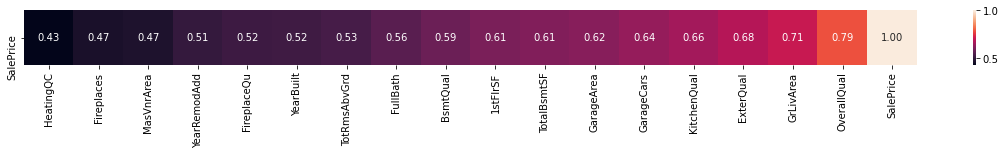

In [16]:
# Draw heatmap for columns with high correlation.
plt.figure(figsize=(20,1))
sns.heatmap(corrs[corrs >= 0.4].to_frame().T, annot=True, fmt='.2f')
plt.show()

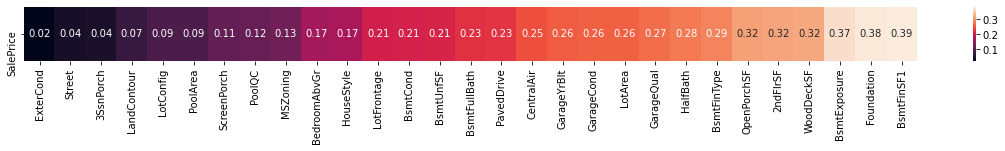

In [17]:
# Draw heatmap for columns with low correlation.
plt.figure(figsize=(20,1))
sns.heatmap(corrs[(corrs >= 0) & (corrs < 0.4)].to_frame().T, annot=True, fmt='.2f')
plt.show()

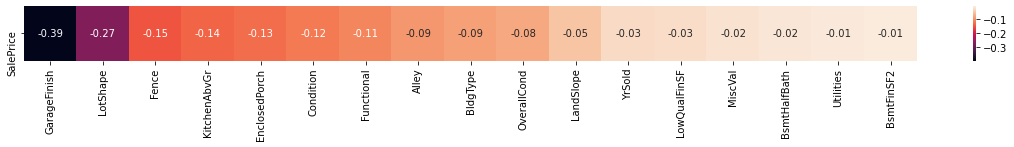

In [18]:
# Draw heatmap for columns with negative correlation.
plt.figure(figsize=(20,1))
sns.heatmap(corrs[corrs < 0].to_frame().T, annot=True, fmt='.2f')
plt.show()

## 3. Build models

### 3.1 Simple linear regression

In [19]:
# Separate output from input columns.
X = train_data.drop('SalePrice', axis=1)
y = train_data['SalePrice'].copy()

# Separate data into training and testing subsets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=324)

In [20]:
# Create and train a classifier using linear regression.
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

# Make predictions.
y_pred = linear_regression.predict(X_test)

# Check the accuracy of the predictions.
MSE = np.mean((y_pred - y_test) ** 2)
RMSE = np.sqrt(MSE)
price_mean = np.mean(y_test)
print('Variance score: %.4f' % linear_regression.score(X_test, y_test))
print("Mean squared error: %.0f" % MSE)
print("Root mean squared error: %.0f" % RMSE)
print("Coefficient of variation: %.4f" % (RMSE / price_mean))

Variance score: 0.7884
Mean squared error: 1217554296
Root mean squared error: 34893
Coefficient of variation: 0.1960


## 4. Make predictions

In [22]:
# Make the predictions using the simple linear regression.
test_data = test_data_raw.drop(USELESS_COLUMNS, axis=1)

test_data.replace(SCORES_TO_NUMBERS, inplace=True)
test_data = test_data.fillna(0)

test_data['Condition'] = test_data['Condition1'] + test_data['Condition2'];
test_data = test_data.drop(['Condition1', 'Condition2'], axis=1)
test_data['BsmtFinType'] = test_data['BsmtFinType1'] + test_data['BsmtFinType2'];
test_data = test_data.drop(['BsmtFinType1', 'BsmtFinType2'], axis=1)

test_predictions = linear_regression.predict(test_data)

# Generate the submission file (to be uploaded to Kaggle).
output = pd.DataFrame({'Id': test_data_raw.Id, 'SalePrice': test_predictions})
output.to_csv('my_submission.csv', index=False)
print("The submission was successfully saved!")

The submission was successfully saved!
